##Loading modules and data

In [106]:
!pip install joblib
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
import joblib
import shap
# Basic stuff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#Parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix , accuracy_score ,classification_report
#Models to select from
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [108]:
#importing data into variables
employee_survey = pd.read_csv('employee_survey_data.csv')
df_general = pd.read_csv('general_data.csv')
manager_survey = pd.read_csv('manager_survey_data.csv')
#Cleaning up some missing values by imputing the mean into employee_survey
employee_survey = employee_survey.fillna(employee_survey.mean())
# Merging dataframe manager_survey to df_general based on 'EmployeeID'
df_general = df_general.merge(manager_survey[['EmployeeID', 'JobInvolvement', 'PerformanceRating']], on='EmployeeID')
df_general.head(2)
# Merging dataframe employee_survey to df_general based on 'EmployeeID'
df_general = df_general.merge(employee_survey[['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction','WorkLifeBalance']], on='EmployeeID')
df_general.dropna(axis=0,inplace=True)
df_general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,29,No,Travel_Rarely,Sales,4,3,Other,1,4405,Female,...,6.0,2,6,1,5,2,3,3.0,4.0,3.0
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,10.0,5,3,0,2,3,3,4.0,1.0,3.0
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,10.0,2,3,0,2,2,3,4.0,4.0,3.0
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,5.0,4,4,1,2,3,4,1.0,3.0,3.0


In [109]:
df_general.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance'],
      dtype='object')

In [110]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4382 entries, 0 to 4408
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4382 non-null   int64  
 1   Attrition                4382 non-null   object 
 2   BusinessTravel           4382 non-null   object 
 3   Department               4382 non-null   object 
 4   DistanceFromHome         4382 non-null   int64  
 5   Education                4382 non-null   int64  
 6   EducationField           4382 non-null   object 
 7   EmployeeCount            4382 non-null   int64  
 8   EmployeeID               4382 non-null   int64  
 9   Gender                   4382 non-null   object 
 10  JobLevel                 4382 non-null   int64  
 11  JobRole                  4382 non-null   object 
 12  MaritalStatus            4382 non-null   object 
 13  MonthlyIncome            4382 non-null   int64  
 14  NumCompaniesWorked      

#Feature Engineering
Dropping missing values, since there is only about 19 out of 4410 rows that contain NaN

In [111]:
df_general = df_general.dropna(axis=0)
df_general.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance'],
      dtype='object')

Dropping useless features

In [112]:
df_general.drop(columns=['EmployeeCount','Over18','StandardHours'], axis = 1, inplace = True)
df_general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


Encoding all columns containing string values, which in this case is all the categorical features

In [113]:
others = df_general.select_dtypes('object').columns
others

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus'],
      dtype='object')

In [114]:
le = LabelEncoder()
for col in others:
    df_general[col] = le.fit_transform(df_general[col])

In [115]:
df_general

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,0,2,2,6,2,1,1,0,1,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,1,1,1,10,1,1,2,0,1,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,0,1,1,17,4,4,3,1,4,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,0,0,1,2,5,1,4,1,3,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,0,2,1,10,1,3,5,1,1,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,29,0,2,2,4,3,4,4405,0,2,...,6.0,2,6,1,5,2,3,3.0,4.0,3.0
4405,42,0,2,1,5,4,3,4406,0,1,...,10.0,5,3,0,2,3,3,4.0,1.0,3.0
4406,29,0,2,1,2,4,3,4407,1,1,...,10.0,2,3,0,2,2,3,4.0,4.0,3.0
4407,25,0,2,1,25,2,1,4408,1,2,...,5.0,4,4,1,2,3,4,1.0,3.0,3.0


Creating the dataframes for prediction value X and and target value Y

In [116]:

x = df_general.drop(['Attrition','EmployeeID'] ,axis =1)
y = df_general['Attrition']
print(x.shape ,y.shape)

(4382, 24) (4382,)


There is some class imbalance which i hope is the reason the models are overfitting

Splitting into training and test sets

First I am gonna fix a class imbalance in the dataset, since there's an uneven proportion of people who have left the company compared to people who have not
Idea and code taken from:
https://www.kaggle.com/code/rajg28/employee-attrition-prediction-all-ml-models#FEATURE-ENGINEERING

In [117]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
x ,y = smote.fit_resample(x ,y)
print(x.shape ,y.shape)

(7354, 24) (7354,)


In [118]:
X_train , X_test , y_train ,y_test = train_test_split(x , y, test_size=0.2 , random_state= 52)
print(X_train.shape)

(5883, 24)


In [119]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


X_train

array([[-0.4894548 , -0.83029995, -0.33556581, ...,  0.3418855 ,
         1.29126806,  1.80162155],
       [ 2.10806832,  0.71352262, -0.33556581, ..., -0.59107441,
         1.29126806,  0.39570357],
       [-1.24706571, -0.83029995, -0.33556581, ...,  0.80728454,
        -1.3735879 , -0.54048916],
       ...,
       [ 1.56691767,  0.71352262, -0.33556581, ...,  0.3418855 ,
        -0.59006317,  0.39570357],
       [-0.92237532,  0.71352262,  1.53034503, ...,  0.3418855 ,
        -1.53072878,  0.39570357],
       [-0.70591506, -0.83029995, -0.33556581, ..., -0.23205543,
        -0.7710553 ,  0.39570357]])

#Trying out logistic regression model

In [120]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
lr_model.score(X_train,y_train)
print("Logistic regression model score: ",lr_model.score(X_train,y_train))

Logistic regression model score:  0.7275199728029916


In [121]:
y_pred_train = lr_model.predict(X_train)

In [122]:
mean_squared_error(y_train, y_pred_train, squared=False)

0.5219961946192792

detected multi-dimensional feature importances but stack=False, using mean to aggregate them.


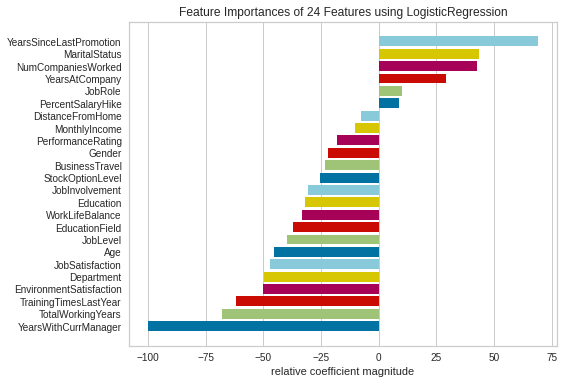

In [123]:
# Feature importance
from yellowbrick.features import FeatureImportances

viz = FeatureImportances(lr_model)
viz.fit(x, y)
viz.show()

In [124]:
k = KFold(n_splits = 5)
lr_score = cross_val_score(lr_model , X_train , y_train ,cv = k ,scoring = 'neg_mean_squared_error')
lr_score.mean()

-0.27689646801796336

#Trying out RandomForest

Creating model

In [125]:
rf_model = RandomForestRegressor()

In [126]:
# Fitting model
rf_model.fit(X_train,y_train)

RandomForestRegressor()

In [127]:
print("RandomForest model score: ",rf_model.score(X_train,y_train)) # Model seems to be overfit to data

RandomForest model score:  0.996280959062727


## Checking feature coefficients

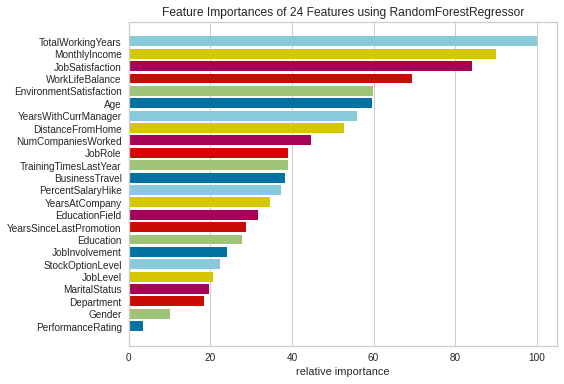

In [128]:
# Feature importance
from yellowbrick.features import FeatureImportances

viz = FeatureImportances(rf_model)
viz.fit(x, y)
viz.show()

##Parameter tuning by doing a grid search based on several parameters and then output the best model out of those: best_reg

In [129]:
# scorer = make_scorer(r2_score)n_estimators=50,max_depth=7,max_features='auto'
scorer = make_scorer(mean_squared_error)

In [130]:
param_grid = {'bootstrap': [False],
 'max_depth': [10, 20, 30, None],
 'min_samples_split': [5, 10],
 'n_estimators': [30]}

In [131]:
# Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(rf_model, param_grid, scoring=scorer)

In [132]:
grid_fit = grid_obj.fit(x, y)

In [133]:
# Get the estimator.
best_reg = grid_fit.best_estimator_

In [134]:
# Fit the new model.
best_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_split=10,
                      n_estimators=30)

In [135]:
# Model performance on TRAIN data
best_reg.score(X_train, y_train)

0.8574796565173672

In [136]:
# Model performance on TEST data
best_reg.score(X_test, y_test)

0.7795768819172906

In [137]:
best_reg.predict(X_test[2,:].reshape(1,-1))

array([1.])

##Saving the model

In [138]:
import pickle

In [139]:
pickle.dump(sc, open('scaler.pkl','wb'))

In [140]:
pickle.dump(le, open('LabelEncoder.pkl','wb'))

In [141]:
!pip install sklearn-json
import sklearn_json as skljson
from sklearn.ensemble import RandomForestClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
joblib.dump(best_reg, 'HR_SML_RF.json', compress=3, protocol=None, cache_size=None)

['HR_SML_RF.json']

In [143]:
best_reg.save_model('best_reg.json')

AttributeError: ignored

In [ ]:
pickle.dump(best_reg, open('best_reg.pkl','wb'))

In [144]:
df_general.to_json('df_general.json.gz')

#Trying out XGBoost model

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model_xgb = XGBRegressor()

In [ ]:
model_xgb.fit(X_train, y_train)

In [ ]:
print('Model XGB' + ' ' + str(model_xgb.score(X_train, y_train)))

In [ ]:
y_pred_train = model_xgb.predict(X_train)

In [ ]:
mean_squared_error(y_train, y_pred_train, squared=False)

In [ ]:
feat_importances = pd.Series(model_xgb.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
explainer = shap.TreeExplainer(model_xgb)

In [ ]:
shap_values = explainer.shap_values(x)

In [ ]:
shap.summary_plot(shap_values, x, plot_type="bar")

In [ ]:
model_xgb.score(y_train, y_pred_train)